# Understanding Urban Housing Trends: A Machine Learning Approach

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Loading and Exploring Dataset

In [7]:
# load dataset
data = pd.read_excel('../STAT4360/Real estate valuation data set.xlsx', index_col=0)
data.index.name = None
data.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [6]:
# look at data information
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 1 to 414
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            414 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [8]:
# Renaming columns for easier usage
data1 = data.rename(columns={
    'X1 transaction date': 'X1',
    'X2 house age': 'X2',
    'X3 distance to the nearest MRT station': 'X3',
    'X4 number of convenience stores': 'X4',
    'X5 latitude': 'X5',
    'X6 longitude': 'X6',
    'Y house price of unit area': 'y'
})
data1.head()

,X1,X2,X3,X4,X5,X6,y
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


## Exploratory Data Analysis

In [9]:
# Select independent variables and dependent variable
X2 = data1['X2']
X3 = data1['X3']
X4 = data1['X4']
X5 = data1['X5']
X6 = data1['X6']
y = data1['y']

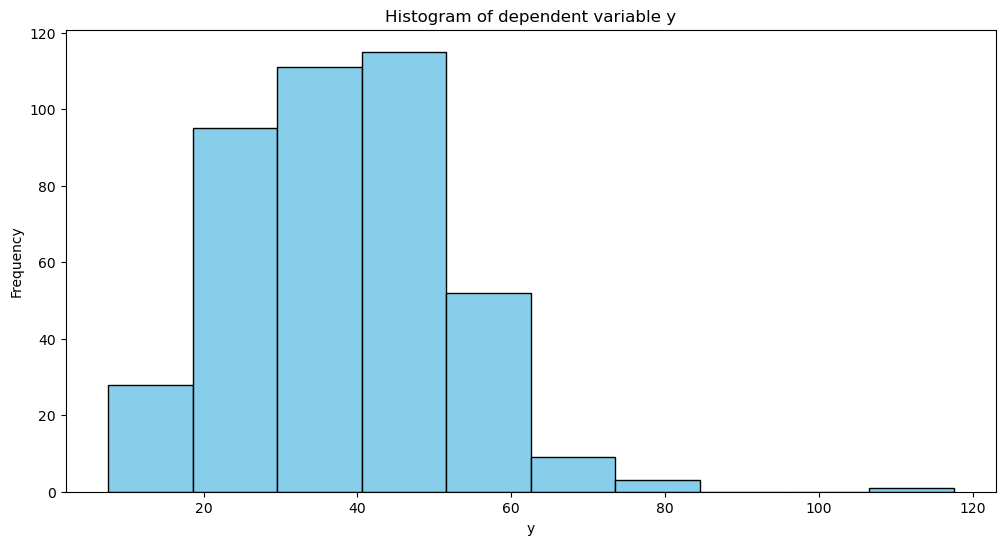

In [10]:
# Plot histogram of the dependent variable
plt.figure(figsize=(12, 6))
plt.hist(y, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('Histogram of dependent variable y')
plt.show()

C:\Users\naujv\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


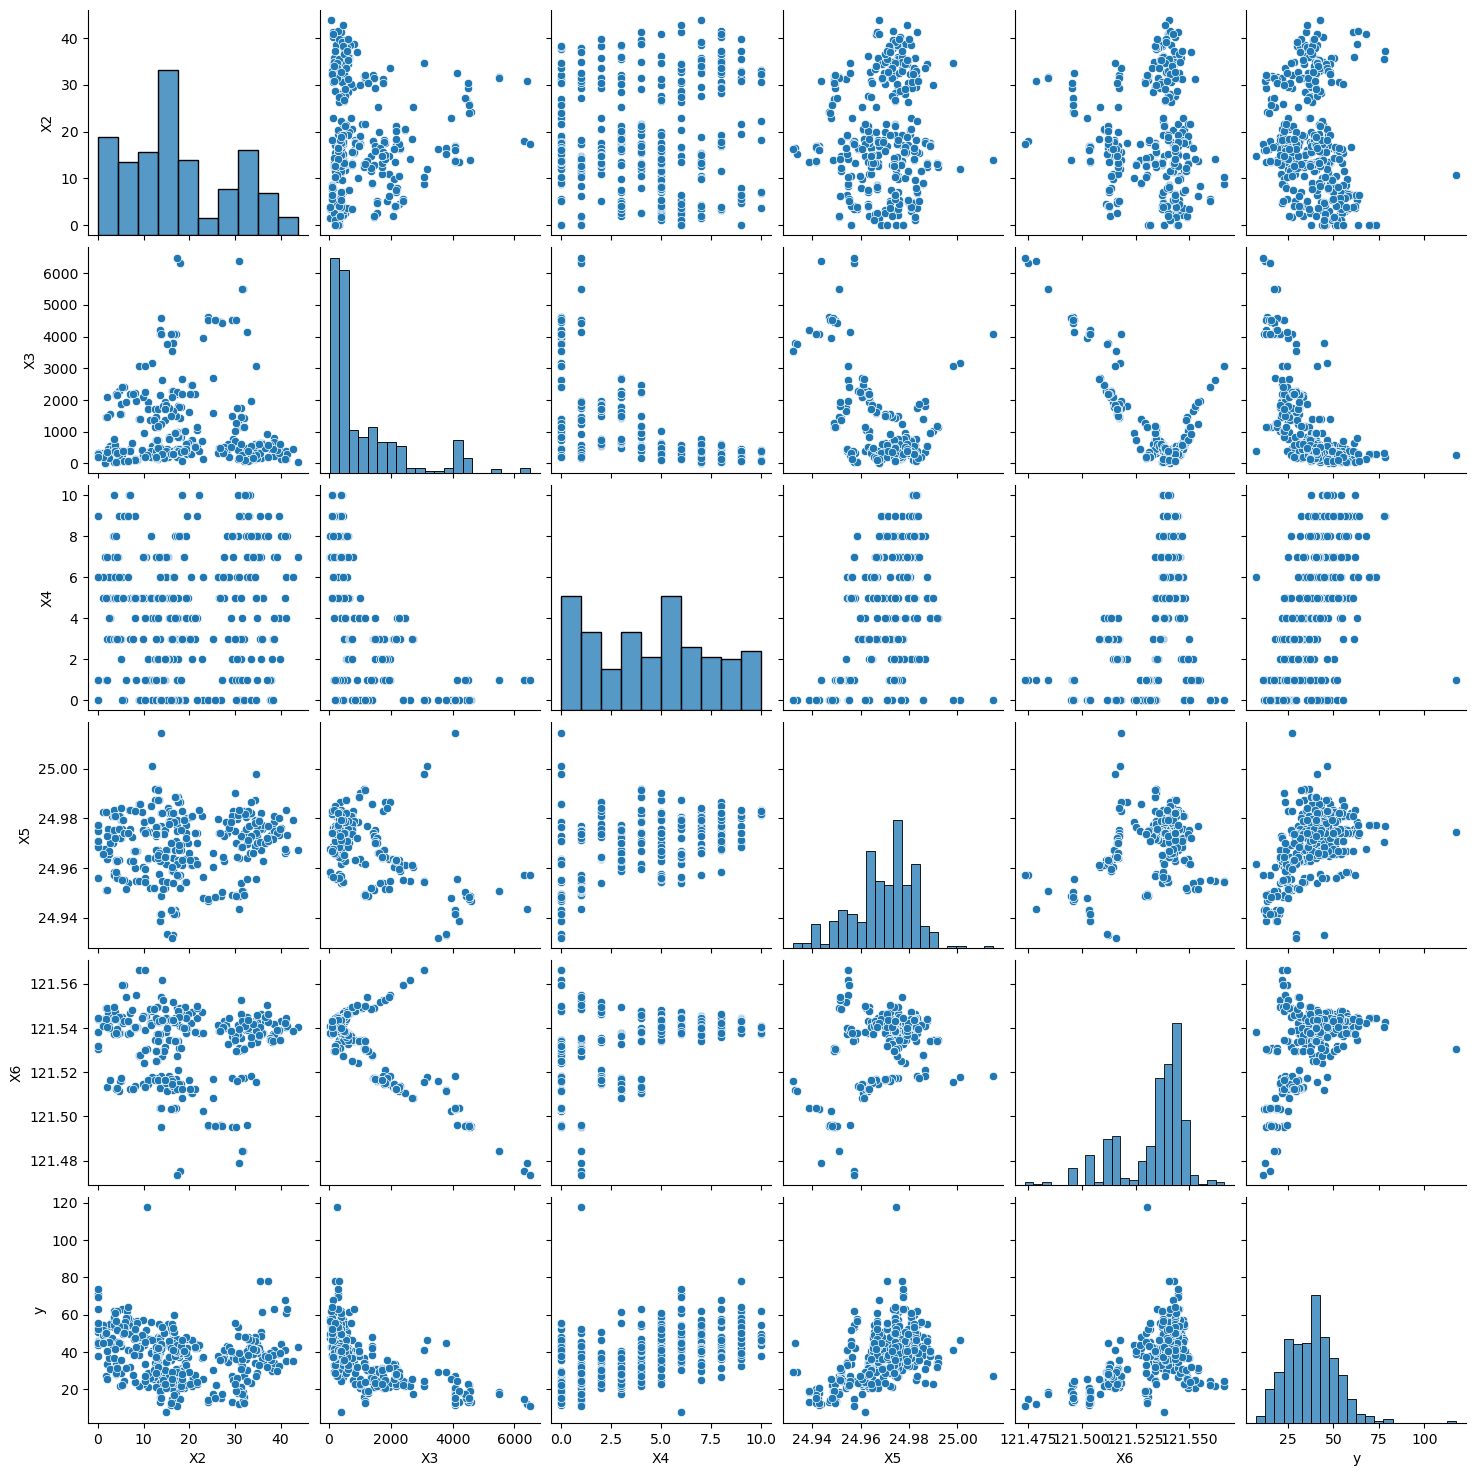

In [11]:
# Pairplot for selected features
sns.pairplot(data1, vars=['X2', 'X3', 'X4', 'X5', 'X6', 'y'])
plt.show()

*Looking at all the relationships between y and the x variables none of them show a strong linear relationship. For X2 and y it shows a decreasing trend at the beginning, but it looks like it is increasing towards the end (maybe a curve). For X3 and y it shows a possible negative linear relationship although it would not be very strong. X4 and y shows a unique pattern, the variables do not look like they have many varying x’s maybe a slight linear pattern as well. X5 and y can possibly have a positive linear relationship although it would be a very weak relationship. In my opinion there is barely any relationship between variable X6 and y. We can see a potential outlier in all the graphs. This would be the point that has a weird y-value. In all the graphs of y against each independent variable there is a point that is by itself in the top of all the graphs.*

## Building the Regression Model

In [12]:
# Fit multiple linear regression model
model = ols('y ~ X2 + X3 + X4 + X5 + X6', data=data1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     108.7
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           9.34e-73
Time:                        14:19:28   Log-Likelihood:                -1492.4
No. Observations:                 414   AIC:                             2997.
Df Residuals:                     408   BIC:                             3021.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4945.5951   6211.157     -0.796      0.4

*Interpreting X3: As the distance to nearest MRT station (x3) increases by 1 unit (and all other variables remain constant) the house price is expected to decrease by .0043. This tells us that as the distance to nearest MRT station increases, the house price is expected to decrease.*

*When testing whether each regression is significant at a 5% significance level, we can see that the regressors x2, x3, x4, and x5 are all significant in helping predict the house price. The regressor x2 has an extremely small p-value (almost 0). Since the p-value is less than .05 we would reject the null (x2 = 0) and conclude that the variable x2 is significant in predicting y. The same would be true for regressors x3, x4, and x5. The only variable that is not significant in predicting y is x6. That is because x6 p-value is .874 which is greater than .05. Meaning that we would not reject the null (x6 = 0) and conclude that x6 is not significant in predicting y.*

## ANOVA table

In [14]:
# Compute total, regression, and residual sums of squares
SST = np.sum((y - np.mean(y))**2)
SSR = np.sum((model.fittedvalues - np.mean(y))**2)
SSE = np.sum((y - model.fittedvalues)**2)

# Compute degrees of freedom
df_reg = 5
df_resid = len(y) - 6
df_total = len(y) - 1

# Compute mean squares
MSR = SSR / df_reg
MSE = SSE / df_resid

# Compute F-statistic and p-value
F = MSR / MSE
p_value = stats.f.sf(F, df_reg, df_resid)

# Create ANOVA table
anova_table = pd.DataFrame({
    'Source': ['Regression', 'Residual', 'Total'],
    'SS': [SSR, SSE, SST],
    'DF': [df_reg, df_resid, df_total],
    'MS': [MSR, MSE, np.nan],
    'F': [F, np.nan, np.nan],
    'p-value': [p_value, np.nan, np.nan]
})
anova_table

,Source,SS,DF,MS,F,p-value
0,Regression,43671.810901,5,8734.362180,108.681515,9.336759e-73
1,Residual,32789.566683,408,80.366585,NaN,NaN
2,Total,76461.377585,413,NaN,NaN,NaN


*The p-value that we would care about is the regression’s p-value. Which is 9.336759e-73. Since we want to look at the global test*

*For the global test the conclusion is that we would reject the null hypothesis (H0: β2=β3=β4=β5=β6) and conclude that at least one of the regressors in the model is significant in predicting y. That is because the p-value 9.336759e-73 is smaller than .05. So we are able to reject the null hypothesis.*

## Hypothesis Testing

In [17]:
# Test if B2 + B3 = B4 and B5 = B6
full_model = ols('y ~ X2 + X3 + X4 + X5 + X6', data=data1).fit()
T = [[0, 1, 1, -1, 0, 0], [0, 0, 0, 0, 1, -1]]
C = [0, 0]
f_test_result = full_model.f_test((T, C))
print(f_test_result)

<F test: F=38.18887536260017, p=6.267571435275453e-16, df_denom=408, df_num=2>


*The results of hypothesis testing is that we can reject the null hypothesis, because the p-value we get is 6.2676e-27 which is less than .05 meaning that the hypothesis (H0:β2+β3=β4. And β5=β6) is not true*

## Model Diagnostics

**Multicollinearity Analysis**

In [20]:
# Compute Variance Inflation Factor (VIF)
X = data1[['X2', 'X3', 'X4', 'X5', 'X6']]
X_with_const = add_constant(X)

vif = pd.DataFrame()
vif['Predictor'] = X_with_const.columns
vif['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

vif = vif[vif['Predictor'] != 'const']  # Exclude constant term
vif

,Predictor,VIF
1,X2,1.014249
2,X3,4.282985
3,X4,1.613339
4,X5,1.599017
5,X6,2.923881


*Based on the results of our VIF there are no significant multicollinearity issues among the predictors. This is because we know that it has to be greater than 5 for it to be considered problematic levels of multicollinearity. Below 2 have very low multicollinearity, 4 and above have moderate levels, but are still passable.*

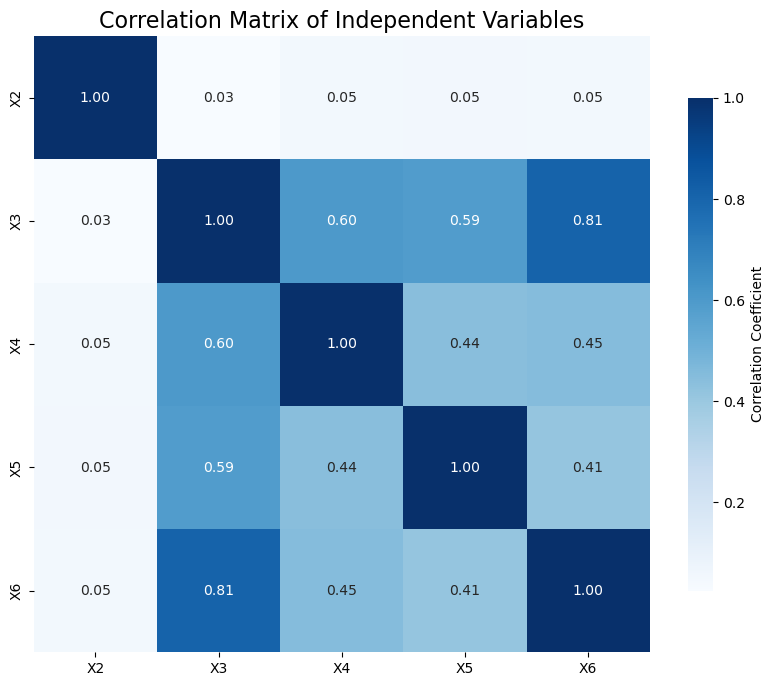

In [21]:
# Plot correlation heatmap
correlation_matrix = X.corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Blues',
            square=True, cbar_kws={'shrink': .8, 'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Independent Variables', fontsize=16)
plt.show()

*The heat map shows that variables x3 and x6 have a high correlation*

**Check Homoscedasticity and Normality**

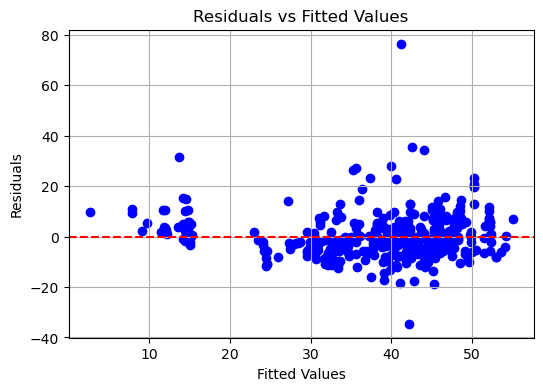

In [22]:
# Residual vs Fitted plot
fitted_values = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.grid(True)
plt.show()

*The assumption of constant variance seems to hold as there is no clear pattern and variance appears to be constant*

In [23]:
# Breusch-Pagan test for heteroscedasticity
X = full_model.model.exog
bp_test = het_breuschpagan(residuals, X)
print(f'Breusch-Pagan Test Statistic: {bp_test[0]}')
print(f'P-value: {bp_test[1]}')


Breusch-Pagan Test Statistic: 4.495597065239514
P-value: 0.48047275176412596


*Since we know that the null hypothesis means that there is constant variance, and our p-value is larger than .05, we fail to reject null hypothesis leading us to conclude that the assumption of constant variance holds*

In [25]:
# Normality tests (Shapiro-Wilk and Kolmogorov-Smirnov)

shapiro_wilk_test = stats.shapiro(residuals)
statistic, p_value = shapiro_wilk_test
print("Shapiro-Wilk Test:")
print("Statistic:", statistic)
print("p-value:", p_value)

ks_test = stats.kstest(residuals, 'norm')
print("\nKolmogorov-Smirnov Test:")
print("Statistic:", ks_test.statistic)
print("p-value:", ks_test.pvalue)


Shapiro-Wilk Test:
Statistic: 0.8681201338768005
p-value: 2.9611415704076347e-18

Kolmogorov-Smirnov Test:
Statistic: 0.4479106909017529
p-value: 2.785860822971567e-76


*Since we know that the null hypothesis for Shapiro-Wilk test is that they are normally distributed, and our p-value is less than .05, we reject the null hypothesis leading us to conclude that the assumption of normality is violated*

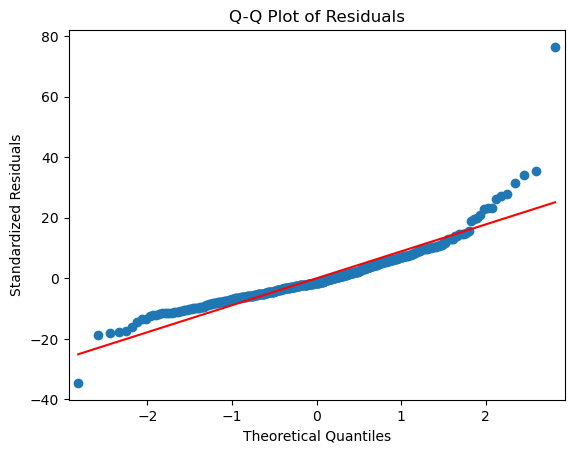

In [26]:
# Q-Q Plot for residuals
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.title('Q-Q Plot of Residuals')
plt.show()

*We can from the Q-Q plot that there are outliers which break the assumption of normality*

**Checking for Influential Points, Outliers, and Leverage Points**

In [29]:
# checking outliers

# first we calculate several metrics to help identify outliers

# Extract residuals, fitted values, influence measures
residuals = model.resid
fitted_values = model.fittedvalues
influence = model.get_influence()


# Get Mean Squared Error directly
mse = model.mse_resid

# Calculate various residuals
standardized_residuals = residuals /np.sqrt(mse)

# Calculate studentized residuals: residuals adjusted for leverage
studentized_residuals = influence.resid_studentized_internal

# Calculate PRESS residuals
hat_matrix_diag = influence.hat_matrix_diag  # Leverage values
press_residuals = residuals / (1 - hat_matrix_diag)



# Calculate R-student residuals: external studentized residuals, accounting for leverage
r_student_residuals = influence.resid_studentized_external


# Calculate leverage values (hii)
leverage_values = influence.hat_matrix_diag

# Calculate standardized PRESS residuals
# Standardized PRESS residuals are the PRESS residuals divided by sqrt(sigma^2(1-h_ii))
# when sigma^2 is estimated by mse; it is equal to studentized

standardized_press_residuals = residuals / np.sqrt(mse * (1 - leverage_values))

# Create a DataFrame with the residuals and leverage values
results_df = pd.DataFrame({
    'Observed': data1['y'],
    'Fitted': fitted_values,
    'Residual': residuals,
    'Standardized Residual': standardized_residuals,
    'Studentized Residual': studentized_residuals,
    'PRESS Residual': press_residuals,
    'PRESS residual square': press_residuals**2,
    'R-Student Residual': r_student_residuals,
    'standardized PRESS_resi.':standardized_press_residuals,
    'Leverage (hii)': leverage_values
    
})

# Display the DataFrame
results_df.head()


,Observed,Fitted,Residual,Standardized Residual,Studentized Residual,PRESS Residual,PRESS residual square,R-Student Residual,standardized PRESS_resi.,Leverage (hii)
1,37.9,48.524624,-10.624624,-1.185157,-1.195004,-10.801913,116.681318,-1.195633,-1.195004,0.016413
2,42.2,49.156749,-6.956749,-0.776012,-0.780008,-7.028574,49.400858,-0.779633,-0.780008,0.010219
3,47.3,46.742782,0.557218,0.062157,0.062492,0.563256,0.317258,0.062416,0.062492,0.010721
4,54.8,46.742782,8.057218,0.898767,0.903624,8.144535,66.333453,0.903421,0.903624,0.010721
5,43.1,47.792728,-4.692728,-0.523465,-0.525462,-4.728603,22.359689,-0.524995,-0.525462,0.007587


*We want to focus on Residual, Standardized Residual, Studentized Residual, R-Student Residual for outliers*

In [30]:
# checking possible outliers


# Columns to check
columns_to_check = ['Residual','Standardized Residual', 'Studentized Residual','R-Student Residual']

# Iterate over each column
for column in columns_to_check:
    print(f"Results for {column}:")
    # Find the absolute values greater than 3
    condition = results_df[column].abs() > 3
    
    # Get the indices where the condition is True
    indices = results_df.index[condition]
    
    # Check if there are any results
    if indices.empty:
        print(f"No values in {column} with absolute value greater than 3.")
    else:
        # Print the index and column name if condition is met
        for idx in indices:
            print(f"  Index: {idx}, Value: {results_df.loc[idx, column]}")
    print()  



Results for Residual:
  Index: 1, Value: -10.62462439575254
  Index: 2, Value: -6.95674926233589
  Index: 4, Value: 8.057217759862098
  Index: 5, Value: -4.6927277613864575
  Index: 9, Value: 10.9578703570475
  Index: 10, Value: -11.31428305684451
  Index: 11, Value: 7.665379603446262
  Index: 12, Value: 5.929997237416707
  Index: 14, Value: -5.734350324957585
  Index: 15, Value: -9.790775937603897
  Index: 16, Value: 14.564272361469875
  Index: 17, Value: 19.859622022669072
  Index: 19, Value: -3.0388434037920007
  Index: 21, Value: -4.653987331111534
  Index: 22, Value: 3.481401190757289
  Index: 23, Value: -5.257889230103409
  Index: 25, Value: 3.219144604279151
  Index: 26, Value: -5.352929604214864
  Index: 27, Value: 7.52726932395224
  Index: 28, Value: -7.679272690368201
  Index: 29, Value: 6.096460201106424
  Index: 30, Value: 11.054715292217203
  Index: 31, Value: 10.362392074099922
  Index: 32, Value: -17.773173430744237
  Index: 34, Value: 3.382871679713432
  Index: 35, Valu

*Based on the four metrics  'Residual', 'Standardized Residual', 'Studentized Residual', 'R-Student Residual', we can see there are several possible outliers: 
Results for Standardized Residual, studentized residuals and R-stduent residuals:
  Index: 114, Value: -3.8535528052174395
  Index: 127, Value: 3.0391419852815575
  Index: 149, Value: 3.5060573309505854
  Index: 221, Value: 3.815296548281626
  Index: 271, Value: 8.519145905667854
  Index: 313, Value: 3.956474160119041
  Index: 390, Value: 3.0939955547614315*

*Usually after finding the outliers we have to determine the amount and if it is less 5 percent of the dataset we can drop them. This approach helps to ensure that outliers, if they are few in number, do not disproportionately affect the overall analysis or model performance.*

In [33]:
# find the leverage value
influence = model.get_influence()
leverage = influence.hat_matrix_diag


# filter the high leverage range
features = ['x2', 'x3', 'x4', 'x5','x6']
n = len(features)
threshold = 2 * (len(model.params) / n)
high_leverage_points = np.where(leverage > threshold)[0]
print(f"Maximum leverage value:{max(leverage)}")
print(f"High leverage points: {high_leverage_points}")
print(f"Leverage values: {leverage[high_leverage_points]}")

Maximum leverage value:0.1287534906461616
High leverage points: []
Leverage values: []


*We can see that there are no high leverage values*

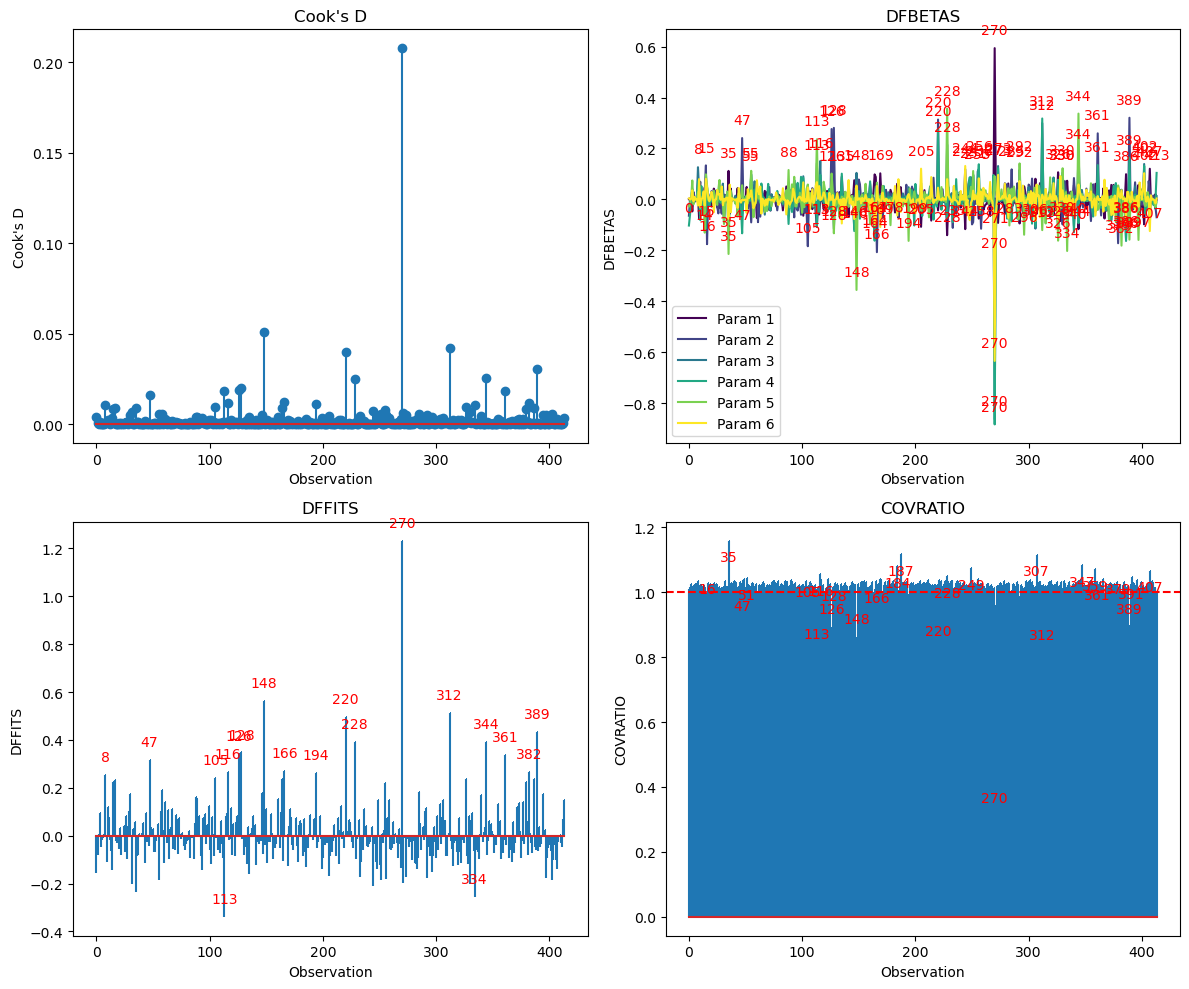

Possible influence points (Cook's D): []
________________________________________________________________________________________
Possible influence points (DFBETAS): [array([ 35, 113, 169, 205, 228, 244, 270, 326, 344, 386, 407], dtype=int64), array([ 15,  16,  47, 105, 126, 128, 164, 166, 220, 233, 244, 258, 270,
       285, 312, 330, 361, 379, 386, 389], dtype=int64), array([  8,  35,  55, 113, 116, 128, 146, 148, 164, 228, 255, 256, 270,
       273, 292, 306, 326, 330, 340, 344, 386, 402], dtype=int64), array([  0,  15,  47, 113, 135, 146, 164, 199, 220, 256, 270, 271, 273,
       306, 312, 330, 340, 361, 386, 389, 402, 413], dtype=int64), array([ 14,  35,  55,  88, 113, 126, 128, 148, 178, 194, 228, 251, 283,
       292, 296, 312, 326, 330, 334, 344, 382, 389, 397], dtype=int64), array([164, 169, 205, 244, 270, 386, 402, 407], dtype=int64)]
_________________________________________________________________________________
Possible influence points (DFFITS): [  8  47 105 113 116 126

,Observation,Cook's D,DFFITS,COVRATIO,0,1,2,3,4,5
0,0,0.003971,-0.154448,1.010288,0.000975,-0.064095,-0.021631,-0.102769,-0.027345,0.004143
1,1,0.001047,-0.079218,1.016171,0.004002,-0.000242,-0.017393,-0.059306,-0.017683,-0.000832
2,2,0.000007,0.006498,1.025772,-0.003267,-0.001474,0.002810,-0.000174,0.005128,0.002434
3,3,0.001475,0.094048,1.013574,-0.047293,-0.021342,0.040679,-0.002524,0.074218,0.035232
4,4,0.000352,-0.045903,1.018446,0.010934,0.029704,-0.005531,0.000452,-0.019634,-0.007685
...,...,...,...,...,...,...,...,...,...,...
409,409,0.000001,0.002734,1.034429,0.000320,-0.000339,0.000747,0.000201,-0.000981,-0.000149
410,410,0.000150,-0.029980,1.026818,0.000239,0.015071,-0.002588,-0.020836,0.002071,-0.000637
411,411,0.000382,-0.047840,1.014089,0.005917,-0.000226,-0.008322,-0.023847,-0.016459,-0.003058
412,412,0.000808,0.069594,1.012138,0.020815,-0.030946,-0.037342,-0.002488,-0.030713,-0.015862


In [35]:
# Calculate influence metrics
cooks_d = influence.cooks_distance[0]
dfbetas = influence.dfbetas
dffits = influence.dffits[0]
covratio = influence.cov_ratio

# Set up the plots
plt.figure(figsize=(12, 10))

# Cook's D Plot
plt.subplot(2, 2, 1)
plt.stem(cooks_d, markerfmt="o")
plt.title("Cook's D")
plt.xlabel('Observation')
plt.ylabel("Cook's D")

# Influence points identification for Cook's D
threshold_cooks_d = 1  # threshold
outliers_cooks_d = np.where(cooks_d > threshold_cooks_d)[0]
for i in outliers_cooks_d:
    plt.annotate(f'{i}', (i, cooks_d[i]), textcoords="offset points", xytext=(0, 8), ha='center', color='red')

# DFBETAS Plot
plt.subplot(2, 2, 2)
num_params = dfbetas.shape[1]
colors = plt.cm.viridis(np.linspace(0, 1, num_params))
labels = [f'Param {i+1}' for i in range(num_params)]

for i in range(num_params):
    plt.plot(dfbetas[:, i], color=colors[i], label=labels[i])
    threshold_dfbetas = 2 / np.sqrt(len(data1['y']))  # threshold
    outliers_dfbetas = np.where(np.abs(dfbetas[:, i]) > threshold_dfbetas)[0]
    for j in outliers_dfbetas:
        plt.annotate(f'{j}', (j, dfbetas[j, i]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

plt.title('DFBETAS')
plt.xlabel('Observation')
plt.ylabel('DFBETAS')
plt.legend(loc='best')

# DFFITS Plot
plt.subplot(2, 2, 3)
plt.stem(dffits, markerfmt=",")
plt.title('DFFITS')
plt.xlabel('Observation')
plt.ylabel('DFFITS')

threshold_dffits = 2 * np.sqrt((len(model.params)) / len(data1['y']))  # threshold
outliers_dffits = np.where(np.abs(dffits) > threshold_dffits)[0]
for i in outliers_dffits:
    plt.annotate(f'{i}', (i, dffits[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

# COVRATIO Plot
plt.subplot(2, 2, 4)
plt.stem(covratio, markerfmt=",")
plt.axhline(y=1, color='r', linestyle='--')
plt.title('COVRATIO')
plt.xlabel('Observation')
plt.ylabel('COVRATIO')

threshold_lower = 1 - 3 * ((len(model.params)) / len(data1['y']))  # lower threshold
threshold_upper = 1 + 3 * ((len(model.params)) / len(data1['y']))  # upper threshold

outliers_covratio_lower = np.where(covratio < threshold_lower)[0]
for i in outliers_covratio_lower:
    plt.annotate(f'{i}', (i, covratio[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')

outliers_covratio_upper = np.where(covratio > threshold_upper)[0]
for i in outliers_covratio_upper:
    plt.annotate(f'{i}', (i, covratio[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='red')

# Adjust subplot layout
plt.tight_layout()
plt.show()

# Output influence points information
print("Possible influence points (Cook's D):", outliers_cooks_d)
print('________________________________________________________________________________________')
possible_influence_points_dfbetas = [np.where(np.abs(dfbetas[:, i]) > threshold_dfbetas)[0] for i in range(num_params)]
print("Possible influence points (DFBETAS):", possible_influence_points_dfbetas)
print('_________________________________________________________________________________')
print("Possible influence points (DFFITS):", outliers_dffits)
print('______________________________________________________________________________________')
print("Possible influence points (COVRATIO):", np.concatenate([outliers_covratio_lower, outliers_covratio_upper]))
print('__________________________________________________________________________________________')

# Find common influence points
common_outliers_dfbetas = set()
for i in range(num_params):
    common_outliers_dfbetas.update(np.where(np.abs(dfbetas[:, i]) > threshold_dfbetas)[0])
common_outliers_dffits = set(outliers_dffits)

# Identify common influence points
common_influence_points = common_outliers_dfbetas.intersection(common_outliers_dffits)

# Include Cook's D in common influence points
common_influence_points_cooks_d_dffits = common_influence_points.intersection(set(outliers_cooks_d))

# Include COVRATIO in common influence points
common_influence_points_all = common_influence_points_cooks_d_dffits.intersection(set(np.concatenate([outliers_covratio_lower, outliers_covratio_upper])))

# Find common influence points for DFBETAS, DFFITS, and COVRATIO
common_influence_points_dfbetas_dffits_covratio = common_outliers_dfbetas.intersection(common_outliers_dffits).intersection(set(np.concatenate([outliers_covratio_lower, outliers_covratio_upper])))

# Print common influence points
print("Common influence points (DFBETAS and DFFITS):", common_influence_points)
print('_________________________________________________________________________________________')
print("Common influence points (Cook's D and DFFITS):", common_influence_points_cooks_d_dffits)
print('__________________________________________________________________________________________')
print("Common influence points (Cook's D, DFBETAS, DFFITS, and COVRATIO):", common_influence_points_all)
print('______________________________________________________________________________________________')
print("Common influence points (DFBETAS, DFFITS, and COVRATIO):", common_influence_points_dfbetas_dffits_covratio)
print('________________________________________________________________________________________________')

# Create a DataFrame for the metrics
metrics_data = {
    'Observation': np.arange(len(data1)),
    'Cook\'s D': cooks_d,
    'DFBETAS': dfbetas.tolist(),
    'DFFITS': dffits,
    'COVRATIO': covratio
}

# Expand DFBETAS into separate columns
dfbetas_df = pd.DataFrame(metrics_data)
dfbetas_expanded = pd.DataFrame(dfbetas_df['DFBETAS'].tolist(), index=dfbetas_df.index)

# Combine into one DataFrame
combined_df = pd.concat([dfbetas_df.drop(columns=['DFBETAS']), dfbetas_expanded], axis=1)

# Display the table
print("\nInfluence Metrics Table:")
(combined_df)




*All the plots give the index 270 as very high influence point. Although it shows quite a few influence points, this may be caused by some outliers*

## Model Prediction

In [37]:
# House age 10, Distance to the nearest MRT station: 500 meters, Number of convenience stores: 3
# Latitude: 24.968, Longitude: 121.537
new_data = pd.DataFrame({
    'X2': [10],          # house age
    'X3': [500],        # distance to nearest MRT station
    'X4': [3],          # number of convenience stores
    'X5': [24.968],     # latitude
    'X6': [121.537]     # longitude
})

new_data_with_const = add_constant(new_data)

predictions = model.get_prediction(new_data_with_const)

predicted_price = predictions.predicted_mean[0]
conf_int = predictions.conf_int(alpha=0.05)

print(f"Predicted House Price: {predicted_price:.4f}")
print(f"95% Confidence Interval: ({conf_int[0][0]:.4f}, {conf_int[0][1]:.4f})")

Predicted House Price: 40.9952
95% Confidence Interval: (39.6386, 42.3517)


*The predicted house price is 40.9952, with a mean 95% Confidence Interval: (39.6386, 42.3517)*

## R^2 interpretation

*R² is 0.571, and adjusted R² is 0.566. An R² of 0.571 indicates that 57.1% of the variance in house prices (y) can be explained by the regressors in the regression model. The adjusted R² is similar but accounts for the number of predictors, penalizing the model for including non-significant variables, which helps provide a more accurate measure of the model's explanatory power.*

## Fitting the standardized regression model with unit normal scaling

In [40]:
x2_normal = (data1['X2'] - data1['X2'].mean()) / data1['X2'].std()
x3_normal = (data1['X3'] - data1['X3'].mean()) / data1['X3'].std()
x4_normal = (data1['X4'] - data1['X4'].mean()) / data1['X4'].std()
x5_normal = (data1['X5'] - data1['X5'].mean()) / data1['X5'].std()
x6_normal = (data1['X6'] - data1['X6'].mean()) / data1['X6'].std()
y_normal = (data1['y'] - data1['y'].mean()) / data1['y'].std()

data_normal = pd.DataFrame({
    'x2': x2_normal, 
    'x3': x3_normal,
    'x4': x4_normal,
    'x5': x5_normal,
    'x6': x6_normal,
    'y': y_normal
})

model_std = ols('y ~ x2 + x3 + x4 + x5 + x6 - 1', data=data_normal).fit()

model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.571
Model:                            OLS   Adj. R-squared (uncentered):              0.566
Method:                 Least Squares   F-statistic:                              108.9
Date:                Thu, 16 Jan 2025   Prob (F-statistic):                    6.14e-73
Time:                        15:25:08   Log-Likelihood:                         -411.68
No. Observations:                 414   AIC:                                      833.4
Df Residuals:                     409   BIC:                                      853.5
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x2            -0.2252      0.033     -6.905      0.000      -0.289      -0.161
x3            -0.3951      0.067     -5.895      0.000      -0.527      -0.263
x4             0.2518      0.041      6.122      0.000       0.171       0.333
x5             0.2169      0.041      5.296      0.000       0.136       0.297
x6            -0.0088      0.055     -0.159      0.874      -0.118       0.100
==============================================================================
Omnibus:                      240.068   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3748.747
Skew:                           2.129   Prob(JB):                         0.00
Kurtosis:                      17.114   Cond. No.                         4.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*The variable that contributes the most to the house price is x3 (Distance to MRT station). That is because it has the largest magnitude (absolute value) of the standardized coefficients, meaning that proximity to MRT station has the strongest effect on price. The further away the house is from the MRT, the larger the price drop.*